# Text analytics - Natural Language Processing

After reviewing this notebook, you will be able to perform basic NLP steps, using mainly the popular spaCy library. 

NLP steps covered in this tutorial include:
- text pre-processing
- tokenization & lemmatization 
- finding keywords & transforming text to ML-usable numeric vectors
- working with meaning through word embeddings (semantic vectors)
- word tagging for named entities - Named Entity Recognition (NER)

------

### NLP with spaCy
https://spacy.io/
(The version used in this tutorial is spaCy 3.4)

First, let's import necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import spacy #spacy is a popular NLP library
from spacy import displacy #displacy enables visualisation of selected spacy outputs

SpaCy works with pre-trained language models which you have to download locally. For this tutorial, we will use the medium-size English model. For a list of models available, see spaCy documentation: https://spacy.io/usage/models

While we're at it, let's get a couple of other packages that will be needed later on.

In [ ]:
# # download the model we will be working with
# !python -m spacy download en_core_web_md
# # install a package for language detection within spacy
# !pip install spacy_langdetect
# # install a package to interact with wikipeida articles
# !pip install wikipedia

Once you have the model downloaded, you have to load it in order to be able to use it. (While you download it once only, you then have to load the model for each session/script.) Note that there is a naming convention to call your loaded model "nlp".

In [2]:
nlp = spacy.load("en_core_web_md")

You can then use the loaded model to process text input. Note that there is a standard way to call your processed document 'doc'.

In [3]:
doc = nlp("John is learning about natural language processing. To learn this in Prague is fun for everyone who loves nature and languages.")
doc

John is learning about natural language processing. To learn this in Prague is fun for everyone who loves nature and languages.

On the first sight, the doc object looks pretty much the same as the text input, but in fact it is already processed and contains many useful linguistic attributes.

From spaCy documentation:

>When you call nlp on a text, spaCy first tokenizes the text to produce a Doc object. The Doc is then processed in several different steps – this is also referred to as the processing pipeline. The pipeline used by the trained pipelines typically includes a tagger, a lemmatizer, a parser and an entity recognizer. Each pipeline component returns the processed Doc, which is then passed on to the next component.

The resulting Doc is split into tokens and has attributes coming from the processing steps (the pipeline can of course be customized to include more or less steps as necessary). You can access the tokens by common slicing methods, and attributes by their name/type (https://spacy.io/api/token). Note that punctuation symbols are also included as individual tokens.


Let's inspect the processed object in a bit more detail. We can have a look at each token, its lemma, its part of speech tag (POS), whether it is a stopword, whether it consists of alphabetic characters, and its named entity (NE) type - if any.

In [4]:
#Nicer format for the output
print("{:<15} {:<15} {:<10} {:<10} {:<10} {:<10}".format(
    'Token','Lemma','POS','stop','alpha','NE'))
# Iterating over the tokens and accessing some of their attributes.
# (Note: attribute .lemma returns a numerical index of each lemma, .lemma_ returns the actual value)
for i in doc:
    print("{:<15} {:<15} {:<10} {:<10} {:<10} {:<10}".format(
        i.text, i.lemma_, i.pos_, i.is_stop, i.is_alpha,i.ent_type_))

# accessing individual tokens & sentences

print("Last 5 tokens: ", doc[-5:])
print("First sentence: ", list(doc.sents)[0])
print("Number of tokens: ", len(doc))
#doc.sents is a generator, to work with the actual sentences, make it into a list 
print("Number of sentences: ", len(list(doc.sents))) 
print("Number of identified entities: ", len(doc.ents), '\n')

Token           Lemma           POS        stop       alpha      NE        
John            John            PROPN      0          1          PERSON    
is              be              AUX        1          1                    
learning        learn           VERB       0          1                    
about           about           ADP        1          1                    
natural         natural         ADJ        0          1                    
language        language        NOUN       0          1                    
processing      processing      NOUN       0          1                    
.               .               PUNCT      0          0                    
To              to              PART       1          1                    
learn           learn           VERB       0          1                    
this            this            PRON       1          1                    
in              in              ADP        1          1                    
Prague      

You can see that the tokens still keep their upper/lower case as well as the exact grammatical form in which they appear in the text, while lemmas have both normalized form and case. Punctuation is also represented as tokens and has its own lemma. For further working with the text, it is better to do some pre-processing so that we keep only the most relevant words in their normalized form.

Side note: spaCy pipelines are language dependent. In case you are dealing with documents in unknown or mixed languages (or aim to categorize documents based on their language), you might want to include language detection as a first step of your pipeline. Language detection in general works more reliably on longer examples.

In [5]:
# necessary imports & adding language detection to the pipeline
from spacy_langdetect import LanguageDetector
from spacy.language import Language
def create_lang_detector(nlp, name):
    return LanguageDetector()

Language.factory("language_detector", func=create_lang_detector)
nlp.add_pipe('language_detector')

In [6]:
texts = ["This is an English example.",
        "Zkusíme i jiné jazyky.",
        "Es funkzioniert ganz gut.",
        "What happens if we do mix jazyky dohromady?",
        "Málo slov",
        "je",
        "těžší určit"]

# Explore the detected languages.
for text in texts:
    doc_detect = nlp(text)
    print(text, doc_detect._.language)

This is an English example. {'language': 'en', 'score': 0.9999969465898443}
Zkusíme i jiné jazyky. {'language': 'cs', 'score': 0.9999952488983818}
Es funkzioniert ganz gut. {'language': 'de', 'score': 0.9999962025662377}
What happens if we do mix jazyky dohromady? {'language': 'en', 'score': 0.7142828533449656}
Málo slov {'language': 'sk', 'score': 0.9999943776869402}
je {'language': 'hr', 'score': 0.9999924595738174}
těžší určit {'language': 'cs', 'score': 0.9999962724231453}


### Text pre-processing

Typical pre-processing steps include: removing punctuation, lowercasing, removing stopwords (frequently occuring words that don't significantly contribute to unique meaning of a text/document), and normalization - either stemming or lemmatization. Resulting normalized text can be further used e.g. as input for ML classification.

Let's have a look at how a text document differs at different stages of pre-processing.

In [7]:
# list of all tokens in a text
tokens = [token.text for token in doc]

# list of all tokens without punctuation and other characters.
# Note that here we simply go for tokens that contain alphabetic characters.
# You could also be more generic and specify which exact character types you would like to avoid:
# tokens_no_punct = [token for token in doc if not token.is_punct | token.is_space]
tokens_no_punct = [token for token in doc if token.is_alpha]

# list of all tokens without punctuation, all lowercase
tokens_no_punct_lower =  [token.text.lower() for token in doc if token.is_alpha]

# list of all lowercased tokens without punctuation + removing stopwords
tokens_no_punct_lower_no_stopwords = [token.text.lower() for token in doc if token.is_alpha & (token.is_stop == False)]

# list of all lemmas without punctuation and stopwords (lemmas have unified case automatically)
lemmas = [token.lemma_ for token in doc if token.is_alpha & (token.is_stop == False)]

# Let's look at some statistics about are sample text.
print("Number of tokens: ", len(tokens))
print("Number of tokens without punctuation: ",len(tokens_no_punct))
print("Number of tokens without punctuation and stopwords: ", len(tokens_no_punct_lower_no_stopwords))
print("Number of lemmas without punctuation and stopwords", len(lemmas))
print("Number of unique tokens without punctuation and stopwords: ", len(set(tokens_no_punct_lower_no_stopwords)))
print("Number of unique lemmas without punctuation and stopwords", len(set(lemmas)))

Number of tokens:  23
Number of tokens without punctuation:  21
Number of tokens without punctuation and stopwords:  11
Number of lemmas without punctuation and stopwords 11
Number of unique tokens without punctuation and stopwords:  11
Number of unique lemmas without punctuation and stopwords 9


You can see that removing stopwords and punctuation significantly shortens the number of items even in such a short text. For processing of longer texts, this can lead to large saving in computing time and resources. Also note that there is a smaller number of unique lemmas than unique tokens, this is because different forms of the same word get united under the same lemma (see the two lists below for a comparison). Also while we did lowercase all the tokens, case is unified automatically for lemmas, lowercasing generic words, but keeping upper case for proper names.

In [8]:
print(sorted(set(tokens_no_punct_lower_no_stopwords)))
print(sorted(set(lemmas)))

['fun', 'john', 'language', 'languages', 'learn', 'learning', 'loves', 'natural', 'nature', 'prague', 'processing']
['John', 'Prague', 'fun', 'language', 'learn', 'love', 'natural', 'nature', 'processing']


##### Hands-on #1
*Let's try all this out on a Wikipedia article. In this exercise we will demonstrate that using pre-processing and filtering out of stopwords and punctuation is crucial for getting meaningful insights from a text.*

*First we get the content of a selected Wikipedia page (simply run the cell bellow).*

In [9]:
import wikipedia
turing = wikipedia.page("Turings test").content
#show first 1000 characters of the text
turing[:1000]

"The Turing test, originally called the imitation game by Alan Turing in 1950, is a test of a machine's ability to exhibit intelligent behaviour equivalent to, or indistinguishable from, that of a human. Turing proposed that a human evaluator would judge natural language conversations between a human and a machine designed to generate human-like responses. The evaluator would be aware that one of the two partners in conversation was a machine, and all participants would be separated from one another. The conversation would be limited to a text-only channel, such as a computer keyboard and screen, so the result would not depend on the machine's ability to render words as speech. If the evaluator could not reliably tell the machine from the human, the machine would be said to have passed the test. The test results would not depend on the machine's ability to give correct answers to questions, only on how closely its answers resembled those a human would give.\nThe test was introduced by 

*Your task is to process the text using spaCy's default pipeline. Then create two separate lists:*

    - tokens_turing, containing simply all the tokens from the text without any preprocessing
    - lemmas_turing, containing all the lemmas from the text, cleaned from punctuation and stop words
    
*Additional questions:*

1. How many sentences are there in the text?
2. What is the last sentence?
3. What is the number of unique tokens and lemmas in the text?

*Hint: You can use set(x) to create a set of unique values from a list x*

    

In [ ]:
# Enter your code here
doc_turing = 
tokens_turing = 
lemmas_turing =



 

In [10]:
# SOLUTION
# nlp = spacy.load("en_core_web_md")
doc_turing = nlp(turing)
tokens_turing = [token.text for token in doc_turing]
lemmas_turing = [token.lemma_ for token in doc_turing if token.is_alpha & (token.is_stop == False)]

print("Number of sentences: ", len(list(doc_turing.sents)))
print("Last sentence: ", list(doc_turing.sents)[-1])
print("Number of unique tokens: ", len(set(tokens_turing)))
print("Number of unique lemmas: ", len(set(lemmas_turing)))

Number of sentences:  320
Last sentence:  Wiki News: "Talk:Computer professionals celebrate 10th birthday of A.L.I.C.E."
Number of unique tokens:  2096
Number of unique lemmas:  1414


*Finally, we can use your prepared lists to see what the most frequent tokens vs lemmas of the text are. Run the following cell to see that text pre-processing not only can save us computing time by reducing the number of analyzed terms, it also leads to more meaningful text summary.*

In [11]:
from collections import Counter
word_freq_tokens = Counter(tokens_turing)
word_freq_lemmas = Counter(lemmas_turing)
print("Most frequent tokens: ", word_freq_tokens.most_common(10), "\n")
print("Most frequent lemmas: ",word_freq_lemmas.most_common(10))

Most frequent tokens:  [('the', 507), (',', 371), ('of', 306), ('.', 305), ('=', 258), ('to', 249), ('a', 247), ('"', 208), ('and', 182), ('that', 164)] 

Most frequent lemmas:  [('test', 171), ('turing', 106), ('machine', 92), ('human', 88), ('intelligence', 57), ('Turing', 46), ('interrogator', 43), ('game', 41), ('computer', 41), ('question', 38)]


*Now that you pre-processed the text, you can actually use the lemmas to generate a quick summary of the text in form of a popular graphic - the wordcloud. Just run the cell bellow to see it.*

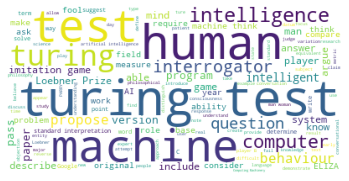

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# Generate word cloud from our lemmas dataset.
# Note that hte wordlcoud library expects input as a string.
word_cloud = WordCloud(background_color = 'white').generate(" ".join(lemmas_turing))
# Display the wordcloud
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

### Feature extraction from a text

Our generated list of lemmas is already just a few lines of code away from having a bag-of-words representation of the whole text. Let's first summarize the preprocessing steps in one function.

In [13]:
def preprocess_text(input_text):
    doc = nlp(input_text)
    # lemmatization of significant tokens of text
    lemmas_cleaned = [token.lemma_ for token in doc if 
                                 token.is_alpha & (token.is_stop == False)]
    # joining tokens into a string
    processed_text = ' '.join(lemmas_cleaned)
    return processed_text

# sample input
texts = ["We love apples and we love cherries.",
       "We love apples and we love bananas.",
        "We love apples and we love pears"]
# pre-process the input
preprocessed = [preprocess_text(t) for t in texts]

Now, with the pre-processed input, we can continue to create the actual Bag-of-Words representation. It will collect all the words form all documents in our processed input and use them as vocabulary, and it will also count the occurences of each vocabulary item in each document. 

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
# initialize the vectorizer
bow = CountVectorizer()
# transform words into a count vector
features_bow = bow.fit_transform(preprocessed)

# get the full vocabulary
vocab_bow = bow.get_feature_names_out()
# saving the word counts as an array (this can then be used as features for ML models)
features_array_bow = features_bow.toarray()
# inspect the vocab file
print(len(vocab_bow))
print(vocab_bow)
print(features_array_bow)

5
['apple' 'banana' 'cherry' 'love' 'pear']
[[1 0 1 2 0]
 [1 1 0 2 0]
 [1 0 0 2 1]]


Let's have a look at the vocabulary sorted by occuerence count. 

In [15]:
features_cherries_bow = dict(zip(vocab_bow, features_array_bow[0]))
features_bananas_bow = dict(zip(vocab_bow, features_array_bow[1]))
features_pears_bow = dict(zip(vocab_bow, features_array_bow[2]))

print(dict(sorted(features_cherries_bow.items(), key=lambda x: x[1], reverse=True)[:10]))
print(dict(sorted(features_bananas_bow.items(), key=lambda x: x[1], reverse=True)[:10]))
print(dict(sorted(features_pears_bow.items(), key=lambda x: x[1], reverse=True)[:10]))

{'love': 2, 'apple': 1, 'cherry': 1, 'banana': 0, 'pear': 0}
{'love': 2, 'apple': 1, 'banana': 1, 'cherry': 0, 'pear': 0}
{'love': 2, 'apple': 1, 'pear': 1, 'banana': 0, 'cherry': 0}


Bag of words is one way of vectorizing a text document. It is based solely on the frequency of occurences of the individual terms, which  might conceal some significant information. Therefore, tfidf (term frequency - inversed document frequency) is typically used for vectorization, as it adds information about which words are specific for a particular document. Let's demonstrate this on our sample sentences.

We can do the vectorization as we did with BoW, getting to the same vocabulary items. However, the assigned values for each vocabulary item are different now.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
features_tfidf = tfidf.fit_transform(preprocessed)

# get the full vocabulary
vocab_tfidf = tfidf.get_feature_names_out()
# saving the word values as an array (this can then be used as features for ML models)
features_array_tfidf = features_tfidf.toarray()
# inspect the vocab file
print(len(vocab_tfidf))
print(vocab_tfidf)
print(features_array_tfidf)

5
['apple' 'banana' 'cherry' 'love' 'pear']
[[0.35653519 0.         0.60366655 0.71307037 0.        ]
 [0.35653519 0.60366655 0.         0.71307037 0.        ]
 [0.35653519 0.         0.         0.71307037 0.60366655]]


Let's inspect the sorted items again.

In [17]:
features_cherries_tfidf = dict(zip(vocab_tfidf, features_array_tfidf[0]))
features_bananas_tfidf = dict(zip(vocab_tfidf, features_array_tfidf[1]))
features_pears_tfidf = dict(zip(vocab_tfidf, features_array_tfidf[2]))

print(dict(sorted(features_cherries_tfidf.items(), key=lambda x: x[1], reverse=True)[:10]))
print(dict(sorted(features_bananas_tfidf.items(), key=lambda x: x[1], reverse=True)[:10]))
print(dict(sorted(features_pears_tfidf.items(), key=lambda x: x[1], reverse=True)[:10]))

{'love': 0.7130703749351064, 'cherry': 0.6036665474310993, 'apple': 0.3565351874675532, 'banana': 0.0, 'pear': 0.0}
{'love': 0.7130703749351064, 'banana': 0.6036665474310993, 'apple': 0.3565351874675532, 'cherry': 0.0, 'pear': 0.0}
{'love': 0.7130703749351064, 'pear': 0.6036665474310993, 'apple': 0.3565351874675532, 'banana': 0.0, 'cherry': 0.0}


You can see that while apples and the other types of fruit had the same value in BoW, in tfidf the other fruit types have higer value than apples. This is because apples are mentioned in all three examples, but the other fruit types are specific to each document, thus adding more information for distinguishing between the three.

##### Hands-on #2

*Now let's practice what we have just learned on another example. Load the following Wikipedia articles about Prague, Brno, Bratislava and Budapest and process them. Get both the bag-of-words and tfidf representation of these articles. Looking at the top 5 words for each city and representation types, which words get bigger importance in the tfidf representation?*

*Hint: You can use the preprocess funciton we defined earlier.*

In [18]:
# get the Wikipedia articles
texts = [wikipedia.page("prague city czech").content, 
         wikipedia.page("brno city").content,
         wikipedia.page("bratislava city").content,
         wikipedia.page("budapest city").content
        ]

In [ ]:
# Your code goes here






*Bonus task: create word clouds for one of the articles.*

In [ ]:
# Your code goes here





In [19]:
# SOLUTION
# preprocess the texts
preprocessed = [preprocess_text(t) for t in texts]

# Bag of Words
bow = CountVectorizer()
features_bow = bow.fit_transform(preprocessed)
# get the full vocabulary
vocab_bow = bow.get_feature_names_out()
# saving the word counts as an array that can then be used as features for ML models
features_array_bow = features_bow.toarray()
# get the dictionaries of words and their values
features_prague_bow = dict(zip(vocab_bow, features_array_bow[0]))
features_brno_bow = dict(zip(vocab_bow, features_array_bow[1]))
features_blava_bow = dict(zip(vocab_bow, features_array_bow[2]))
features_buda_bow = dict(zip(vocab_bow, features_array_bow[3]))
# print sorted results
print("Bag of Words")
print(dict(sorted(features_prague_bow.items(), key=lambda x: x[1], reverse=True)[:5]))
print(dict(sorted(features_brno_bow.items(), key=lambda x: x[1], reverse=True)[:5]))
print(dict(sorted(features_blava_bow.items(), key=lambda x: x[1], reverse=True)[:5]))
print(dict(sorted(features_buda_bow.items(), key=lambda x: x[1], reverse=True)[:5]))
print("\n")

# tfidf
tfidf = TfidfVectorizer()
features_tfidf = tfidf.fit_transform(preprocessed)
# get the full vocabulary
vocab_tfidf= tfidf.get_feature_names_out()
# saving the word values as an array that can then be used as features for ML models
features_array_tfidf = features_tfidf.toarray()
# get the dictionaries of words and their values
features_prague_tfidf = dict(zip(vocab_tfidf, features_array_tfidf[0]))
features_brno_tfidf = dict(zip(vocab_tfidf, features_array_tfidf[1]))
features_blava_tfidf = dict(zip(vocab_tfidf, features_array_tfidf[2]))
features_buda_tfidf = dict(zip(vocab_tfidf, features_array_tfidf[3]))
# print sorted results
print(dict(sorted(features_prague_tfidf.items(), key=lambda x: x[1], reverse=True)[:5]))
print(dict(sorted(features_brno_tfidf.items(), key=lambda x: x[1], reverse=True)[:5]))
print(dict(sorted(features_blava_tfidf.items(), key=lambda x: x[1], reverse=True)[:5]))
print(dict(sorted(features_buda_tfidf.items(), key=lambda x: x[1], reverse=True)[:5]))

Bag of Words
{'prague': 207, 'city': 107, 'czech': 47, 'include': 26, 'world': 24}
{'brno': 180, 'city': 99, 'czech': 50, 'theatre': 33, 'republic': 28}
{'bratislava': 157, 'city': 107, 'slovak': 68, 'slovakia': 47, 'hungarian': 31}
{'budapest': 261, 'city': 179, 'hungarian': 86, 'hungary': 78, 'district': 55}


{'prague': 0.7073937706557636, 'city': 0.3656576495660227, 'czech': 0.16061597691217822, 'praha': 0.14407046754999675, 'bohemia': 0.117875837086361}
{'brno': 0.8285709300377742, 'city': 0.3016324348436922, 'moravian': 0.15764057436098244, 'czech': 0.1523396135574203, 'theatre': 0.10054414494789739}
{'bratislava': 0.6295485661002411, 'city': 0.35078089707619947, 'slovak': 0.336802581297788, 'slovakia': 0.23279001942641228, 'hungarian': 0.10162811036787088}
{'budapest': 0.644192277378617, 'city': 0.3612023838112539, 'hungary': 0.19251723232004647, 'hungarian': 0.17353857546239015, 'buda': 0.16462874921050072}


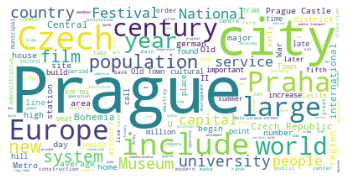

In [20]:
# SOLUTION - WORDCLOUD BONUS
# Get a list of lemmas for the Prague article - that's te first item of the preprocessed list 
# created above (or the result of calling our preprocess_text function on the article text)
lemmas = preprocessed[0]
# The preprocessed text is already one connected string of all the relevant lemmas
word_cloud = WordCloud(background_color = 'white').generate(lemmas)
# Display the wordcloud
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

### Word embeddings

The spaCy library also allows you to convert words and entire documents into their vector representation based on their meaning. The library uses a embedding model, which was trained on an extensive corpus. Getting word embeddings is part of the default spacy pipeline, you can access them with the .vector attribute. (Note that the small English model comes without word vectors)

In [21]:
word = nlp("dog")

# the word embedding is simply a very long array (here 300), placing the word in a multi-dimensional space
print(word.vector.shape)
word.vector[:50]

(300,)


array([ 1.2330e+00,  4.2963e+00, -7.9738e+00, -1.0121e+01,  1.8207e+00,
        1.4098e+00, -4.5180e+00, -5.2261e+00, -2.9157e-01,  9.5234e-01,
        6.9880e+00,  5.0637e+00, -5.5726e-03,  3.3395e+00,  6.4596e+00,
       -6.3742e+00,  3.9045e-02, -3.9855e+00,  1.2085e+00, -1.3186e+00,
       -4.8886e+00,  3.7066e+00, -2.8281e+00, -3.5447e+00,  7.6888e-01,
        1.5016e+00, -4.3632e+00,  8.6480e+00, -5.9286e+00, -1.3055e+00,
        8.3870e-01,  9.0137e-01, -1.7843e+00, -1.0148e+00,  2.7300e+00,
       -6.9039e+00,  8.0413e-01,  7.4880e+00,  6.1078e+00, -4.2130e+00,
       -1.5384e-01, -5.4995e+00,  1.0896e+01,  3.9278e+00, -1.3601e-01,
        7.7732e-02,  3.2218e+00, -5.8777e+00,  6.1359e-01, -2.4287e+00],
      dtype=float32)

The spaCy library also allows you to convert words and entire documents into their vector representation based on their meaning. The library uses a embedding model, which was trained on an extensive corpus.

The created vector representations (embeddings) reflect the semantic relationships between words and can be used, for example, to compare words, sentences or whole documents with each other. This is done by calculating the cosine similarity of the compared vectors.

Getting word embeddings is part of the default spacy pipeline, you can access them with the .vector attribute. (Note that the small English model comes without word vectors)

In [22]:
word1 = nlp("dog")
word2 = nlp("cat")
word3 = nlp("car")
print("word1 to word2: ", word1.similarity(word2))
print("word1 to word3: ", word1.similarity(word3))
print("word2 to word3: ", word2.similarity(word3))

word1 to word2:  0.82208162391359
word1 to word3:  0.32500253978692867
word2 to word3:  0.19698592764608053


We can look also on whole sequences of text.

For spacy, this works by default in the same manner as for words. The embedding of a sentence is an average of its individual word embeddings. Note that this not take into account syntactical relationships nor word order and meaning of longer sequenes can get dilluted with generic words.

In [23]:
sent1 = "Kids are happy."
sent2 = "Children are not sad."
sent3 = "Adults are sad."

In [24]:
print("sent1 to sent2: ", nlp(sent1).similarity(nlp(sent2)))
print("sent1 to sent3: ", nlp(sent1).similarity(nlp(sent3)))
print("sent2 to sent3: ", nlp(sent2).similarity(nlp(sent3)))

sent1 to sent2:  0.8410270719280944
sent1 to sent3:  0.8958285782398148
sent2 to sent3:  0.907383759736349


For better results, it is better to use models trained specifically to embed sentences. Through spacy we can test Google's Universal Sentence Encoder


In [25]:
# !pip install spacy_universal_sentence_encoder

import spacy_universal_sentence_encoder
nlp_use = spacy_universal_sentence_encoder.load_model('en_use_md')
print("sent1 to sent2: ", nlp_use(sent1).similarity(nlp_use(sent2)))
print("sent1 to sent3: ", nlp_use(sent1).similarity(nlp_use(sent3)))
print("sent2 to sent3: ", nlp_use(sent2).similarity(nlp_use(sent3)))


sent1 to sent2:  0.606809973137763
sent1 to sent3:  0.4132786416630257
sent2 to sent3:  0.5663202726779119


In the same way, Sentence BERT can be used through spacy.

In [26]:
#!pip install spacy-sentence-bert

import spacy_sentence_bert
# load one of the models listed at https://github.com/MartinoMensio/spacy-sentence-bert/
nlp_sbert = spacy_sentence_bert.load_model('en_nli_distilbert_base')

print("sent1 to sent2: ", nlp_sbert(sent1).similarity(nlp_sbert(sent2)))
print("sent1 to sent3: ", nlp_sbert(sent1).similarity(nlp_sbert(sent3)))
print("sent2 to sent3: ", nlp_sbert(sent2).similarity(nlp_sbert(sent3)))

sent1 to sent2:  0.8475940212126944
sent1 to sent3:  0.3888499615173781
sent2 to sent3:  0.4613629728923686


You can see that unlike the word-based model, the sentence-based ones actually understand the negation in the sentence.


##### Hands-on #3
*Process the following newspaper headlines and try to find the most similar one(s) to the provided target headline. Try different models to see if there are any differences in their scoring.*


In [32]:
target_headline = "Schools are reopening after closure due to Covid."
headlines = ["New road closure.",
             "Shops reopened after the brief holiday season.",
            "Rising Covid cases might be a warning sign.",
             "A top university opened its lectures to public.",
             "Universities welcomed their students back after the Covid break.",
            "Kids are returning to their classrooms after the epidemic.",
             "Schools still not opening due to Covid.",
            "The Covid-19 epidemic opened up many new questions."]

In [ ]:
# Your code goes here





In [33]:
# SOLUTION
# to make experimenting with different models easy, let's wrap up the processing steps into a function
def process_headlines(model_name, spacy_model, target_headline, headlines):
    target = spacy_model(target_headline)
    scores = []
    # process headlines and get their similarity score to the target headline
    for h in headlines:
        scores += [spacy_model(h).similarity(target)]
    scored = dict(zip(headlines, scores))
    # print top 3 results
    print(model_name, dict(sorted(scored.items(), key=lambda x: x[1], reverse=True)[:3]),"\n")
    

# spacy en core md model
import spacy
nlp = spacy.load("en_core_web_md")
process_headlines("EN CORE WEB MD", nlp, target_headline, headlines)

# USE through spacy
import spacy_universal_sentence_encoder
nlp_use = spacy_universal_sentence_encoder.load_model('en_use_md')
process_headlines("USE", nlp_use, target_headline, headlines)

# sentence transformers through spacy
import spacy_sentence_bert
nlp_sbert = spacy_sentence_bert.load_model('en_nli_distilbert_base')
process_headlines("Sentence distilbert", nlp_sbert, target_headline, headlines)

EN CORE WEB MD {'Schools still not opening due to Covid.': 0.9312465656129983, 'Kids are returning to their classrooms after the epidemic.': 0.8824672918732744, 'Universities welcomed their students back after the Covid break.': 0.8310456530036732} 

USE {'Schools still not opening due to Covid.': 0.6298517399724496, 'Kids are returning to their classrooms after the epidemic.': 0.4336529031331457, 'Shops reopened after the brief holiday season.': 0.4303796474851874} 

Sentence distilbert {'Universities welcomed their students back after the Covid break.': 0.7313619395553626, 'Shops reopened after the brief holiday season.': 0.7241327559959376, 'Kids are returning to their classrooms after the epidemic.': 0.680461033157484} 



*As a bonus, you can play around with the following cells and find out what the semantically closest words are to your input words or what happens if you do some basic arithmetic with words.Try to come up with a good triade of words for that!*

*We will demonstrate this using a pre-trained GenSim model for a change.*

In [34]:
#necessary imports
import gensim
import gensim.downloader as api
model = api.load("glove-wiki-gigaword-50")

*This is how you can get a list of words with most similar vectors*

In [35]:
model.most_similar("queen")

[('princess', 0.8515166640281677),
 ('lady', 0.8050609230995178),
 ('elizabeth', 0.7873042225837708),
 ('king', 0.7839043736457825),
 ('prince', 0.7821860909461975),
 ('coronation', 0.769277811050415),
 ('consort', 0.7626097202301025),
 ('royal', 0.7442865371704102),
 ('crown', 0.7382649779319763),
 ('victoria', 0.7285771369934082)]

*And this is how you can calculate with words*

In [36]:
model.most_similar(positive=['king', 'woman'], negative=['man'])

[('queen', 0.8523604273796082),
 ('throne', 0.7664334177970886),
 ('prince', 0.759214460849762),
 ('daughter', 0.7473882436752319),
 ('elizabeth', 0.7460219860076904),
 ('princess', 0.7424570322036743),
 ('kingdom', 0.7337411642074585),
 ('monarch', 0.721449077129364),
 ('eldest', 0.7184861898422241),
 ('widow', 0.7099431157112122)]

In [ ]:
# space for your own experiments






### Named entity recognition (NER)
NER is part of the default spaCy pipeline. It uses a pretrained model to identify entities, there are different models for different languages, they might differ in the number of entities they are able to identify and their success rate. For specific entities, other languages or higher success rate, you might need to look for other NER packages/models or train a model of your own.

Entities are all grouped under the .ents attribute of your doc, all you can access them directly from a token through .ent_type_ attribute. Each word in an entity also has a flag, whether it is the first word of an entity (B - beginning) or a subsequent word of an entity (I - in) - this can be checked by the .ent_iob_ attribute (non-entities have O - out - as their attribute)

In [37]:
# define text document
text = """Robin is watching a robin eating an apple on her Apple laptop. 
          I bought a second jersey in New Jersey yesterday for 20 dollars. 
          We are sitting at Deloitte office in Vinohrady at 10 am."""
doc = nlp(text)

# Check the recognised entities
print("Identified entities: ", [(ent.text, ent.label_) for ent in doc.ents])
# Highlight identified entities directly in text    
displacy.render(doc, style="ent", jupyter=True)

#Explain a tag
print("GPE: ", spacy.explain("GPE"))
print("ORG: ", spacy.explain("ORG"))
print("\n")

# Let's have a look at the tags accessed directly from the tokens
# last 4 tokens as an example
for t in doc[-4:]:
    print(t, t.ent_type_, t.ent_iob_)

Identified entities:  [('Robin', 'PERSON'), ('Apple', 'ORG'), ('second', 'ORDINAL'), ('New Jersey', 'GPE'), ('yesterday', 'DATE'), ('20 dollars', 'MONEY'), ('Deloitte', 'ORG'), ('Vinohrady', 'PERSON'), ('10 am', 'TIME')]


GPE:  Countries, cities, states
ORG:  Companies, agencies, institutions, etc.


at  O
10 TIME B
am TIME I
.  O


##### Hands-on #4

*Take the input texts and inspect the entities they contain. Then replace any named people by the string "ANONYMIZED"*

*Hint: You can access the entity type of a token using the ent_type_ attribute*

In [38]:
text = """James Martin Brown was arrested for bribing Jane Newman in California.
        Katie had pneumonia in October. Jim, Marie and Bob Adams were accused of assaulting
        their cousin David Lim."""  

In [ ]:
# Your code goes here





In [39]:
# SOLUTION
doc = nlp(text)

# Let's first have a look at the entities identified
displacy.render(doc, style="ent", jupyter=True)

# simple solution, replacing any PERSON-tagged token with "ANONYMIZED"
x = [token.text if token.ent_type_ != "PERSON" else "ANONYMIZED" for token in doc]
print("Simple solution: ", " ".join(x), "\n")

# Note: in the simple solution above, you would get ANONYMIZED ANONYMIZED in case both 
# a name and a surname are mentioned in the text. If you would rather get just one ANONYMIZED,
# you can also work with the tags marking whether a word is a beginning of an entity (B) or 
# following words of an entity (I)
x = [token.text if token.ent_type_ != "PERSON" else "ANONYMIZED" if 
     token.ent_iob_ == "B" else "" for token in doc]
print("Better solution: ", " ".join(x))

Simple solution:  ANONYMIZED ANONYMIZED ANONYMIZED was arrested for bribing ANONYMIZED ANONYMIZED in California . 
         ANONYMIZED had pneumonia in October . ANONYMIZED , ANONYMIZED and ANONYMIZED ANONYMIZED were accused of assaulting 
         their cousin ANONYMIZED ANONYMIZED . 

Better solution:  ANONYMIZED   was arrested for bribing ANONYMIZED  in California . 
         ANONYMIZED had pneumonia in October . ANONYMIZED , ANONYMIZED and ANONYMIZED  were accused of assaulting 
         their cousin ANONYMIZED  .


### Transformer taster

As you have seen on the sentence models, transformers can be to some extent used directly from spacy. If not necessarily including into an existing spacy pipeline, transformer models are typically used and fine-tuned using the transformers library from huggingface.

Let's have a look at how you can load and use a pre-trained model from the transformers library.

For an overview of available models, have a look here: https://huggingface.co/models .
Note that on the left, you can filter available models based on language and specific task.


Models pre-trained for specific tasks such as sentiment analysis can be easily used with the help of prepared pipelines


In [40]:
text = ["Learning about NLP is fun!", "I am sad that no one told me before.", "Now I can start learning."]

In [41]:
from transformers import pipeline
# The pipeline we want to use now is "text-classification" as sentiment analysis is a classification task.
# Note that in this case, you can also use the "sentiment-analysis" pipeline name, leading to the same results.
# If you go for a specific model from the higgingface hub, you don't need to specify pipeline 
# if it is already defined by the model
# When selecting a pipeline, specification of a model is optional, there is always a default model and corresponding tokenizer per pipeline,
# let's try the default model out
sentiment_task = pipeline("text-classification")
# to the pipeline you can pass either a single string or a list of strings
sentiment_task(text)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9998666048049927},
 {'label': 'NEGATIVE', 'score': 0.9979484677314758},
 {'label': 'POSITIVE', 'score': 0.998705267906189}]

In [42]:
# let's check scores from a model trained on twitter data.
sentiment_task = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment-latest", 
                          tokenizer="cardiffnlp/twitter-roberta-base-sentiment-latest")
# to the pipeline you can pass either a single string or a list of strings
sentiment_task(text)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'label': 'positive', 'score': 0.9773547053337097},
 {'label': 'negative', 'score': 0.9165840148925781},
 {'label': 'positive', 'score': 0.6659218072891235}]

We can have a look at the steps that are hidden under the pipeline hood. To pass your text through the model, you first have to tokenize it and shape it into format expected by the model, which might require padding and/or truncating. your text to a fixed length

In [43]:
# first let's tokenize our input text
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
inputs = tokenizer(text, return_tensors="pt",padding=True)

In [44]:
# then let's use the model to predict
from transformers import AutoModelForSequenceClassification, AutoConfig
from scipy.special import softmax

model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
# loading the config is useful to be able to access the label mapping later
config = AutoConfig.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

encoded_input = tokenizer(text, return_tensors='pt', padding=True)
# passing the preprocessed input text to the model
output = model(**encoded_input)
# let's have a look how the output looks like
output

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SequenceClassifierOutput(loss=None, logits=tensor([[-2.7091, -0.6250,  3.2572],
        [ 2.3943, -0.0991, -2.3880],
        [-2.7386,  0.8448,  1.5620]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [45]:
# iterate over the results per sample
for t, res in zip(text, output.logits): 
    # apply softmax to get scores 0-100. We need to convert to numpy format first
    res = softmax(res.detach().numpy())
    # get the category with the highest score
    predicted_class_id = res.argmax().item()
    # find a corresponding label
    label = model.config.id2label[predicted_class_id]
    # check the highest score and the corresponding label
    print(t, "\t", label, max(res))

Learning about NLP is fun! 	 positive 0.9773547
I am sad that no one told me before. 	 negative 0.916584
Now I can start learning. 	 positive 0.6659214


##### Hands-on #5
*Go to https://huggingface.co/models and find a model pre-trained for named entity recognition (NER). Use it to identify entities in the sample texts below. Feel free to compare outputs of several different models.*

*Hint: NER is a token classificaiton task.*

*Hint 2: You can use the ner pipeline.*


In [46]:
texts = ["Robin is watching a robin eating an apple on her Apple laptop.",
         "I bought a second jersey in New Jersey yesterday for 20 dollars.",
         "We are sitting at Deloitte office in Vinohrady at 10 am."]

In [ ]:
# Your code goes here





In [47]:
# SOLUTION option 1

# default model in the NER pipeline
ner = pipeline("ner")
ner(texts)

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[[{'entity': 'I-PER',
   'score': 0.9891065,
   'index': 1,
   'word': 'Robin',
   'start': 0,
   'end': 5},
  {'entity': 'I-ORG',
   'score': 0.9316223,
   'index': 11,
   'word': 'Apple',
   'start': 49,
   'end': 54}],
 [{'entity': 'I-LOC',
   'score': 0.99959224,
   'index': 7,
   'word': 'New',
   'start': 28,
   'end': 31},
  {'entity': 'I-LOC',
   'score': 0.999323,
   'index': 8,
   'word': 'Jersey',
   'start': 32,
   'end': 38}],
 [{'entity': 'I-ORG',
   'score': 0.99917525,
   'index': 5,
   'word': 'Del',
   'start': 18,
   'end': 21},
  {'entity': 'I-ORG',
   'score': 0.9896628,
   'index': 6,
   'word': '##oit',
   'start': 21,
   'end': 24},
  {'entity': 'I-ORG',
   'score': 0.99808156,
   'index': 7,
   'word': '##te',
   'start': 24,
   'end': 26},
  {'entity': 'I-LOC',
   'score': 0.99478084,
   'index': 10,
   'word': 'Vin',
   'start': 37,
   'end': 40},
  {'entity': 'I-LOC',
   'score': 0.9361024,
   'index': 11,
   'word': '##oh',
   'start': 40,
   'end': 42},
  

In [48]:
# SOLUTION option 2

# XLM RoBERTa model
ner = pipeline("ner", model="xlm-roberta-large-finetuned-conll03-english",
              tokenizer="xlm-roberta-large-finetuned-conll03-english")
ner(texts)


[[{'entity': 'I-PER',
   'score': 0.9998919,
   'index': 1,
   'word': '▁Robin',
   'start': 0,
   'end': 5},
  {'entity': 'I-ORG',
   'score': 0.68460315,
   'index': 12,
   'word': '▁Apple',
   'start': 49,
   'end': 54}],
 [{'entity': 'I-LOC',
   'score': 0.99999774,
   'index': 7,
   'word': '▁New',
   'start': 28,
   'end': 31},
  {'entity': 'I-LOC',
   'score': 0.99999714,
   'index': 8,
   'word': '▁Jersey',
   'start': 32,
   'end': 38}],
 [{'entity': 'I-ORG',
   'score': 0.99998164,
   'index': 5,
   'word': '▁Deloitte',
   'start': 18,
   'end': 26},
  {'entity': 'I-LOC',
   'score': 0.99999154,
   'index': 8,
   'word': '▁Vino',
   'start': 37,
   'end': 41},
  {'entity': 'I-LOC',
   'score': 0.99998665,
   'index': 9,
   'word': 'hrad',
   'start': 41,
   'end': 45},
  {'entity': 'I-LOC',
   'score': 0.999944,
   'index': 10,
   'word': 'y',
   'start': 45,
   'end': 46}]]

In [49]:
# SOLUTION option 3

# a model trained for more entity classes
ner = pipeline("ner", model="tner/roberta-large-ontonotes5",
              tokenizer="tner/roberta-large-ontonotes5")
ner(texts)

[[{'entity': 'B-PERSON',
   'score': 0.9994404,
   'index': 1,
   'word': 'Robin',
   'start': 0,
   'end': 5},
  {'entity': 'B-ORG',
   'score': 0.99949026,
   'index': 12,
   'word': 'ĠApple',
   'start': 49,
   'end': 54}],
 [{'entity': 'B-ORDINAL',
   'score': 0.9871154,
   'index': 4,
   'word': 'Ġsecond',
   'start': 11,
   'end': 17},
  {'entity': 'B-GPE',
   'score': 0.99830925,
   'index': 7,
   'word': 'ĠNew',
   'start': 28,
   'end': 31},
  {'entity': 'I-GPE',
   'score': 0.99941325,
   'index': 8,
   'word': 'ĠJersey',
   'start': 32,
   'end': 38},
  {'entity': 'B-DATE',
   'score': 0.96936125,
   'index': 9,
   'word': 'Ġyesterday',
   'start': 39,
   'end': 48},
  {'entity': 'B-MONEY',
   'score': 0.9997522,
   'index': 11,
   'word': 'Ġ20',
   'start': 53,
   'end': 55},
  {'entity': 'I-MONEY',
   'score': 0.9992404,
   'index': 12,
   'word': 'Ġdollars',
   'start': 56,
   'end': 63}],
 [{'entity': 'B-ORG',
   'score': 0.9998547,
   'index': 5,
   'word': 'ĠDel',
   '